Takes in .AWD, sleep log if it exists, calendar, and spits out some pretty pictures

In [129]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, '/data/MoodGroup/actigraphy/gavi/actigraPy') 

import actigraPy.actigraPy as act
import importlib
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

If you want to run the test data, run this cell instead of the one below

In [ ]:
# data and log directories
sub = 'TEST' #subject NUMBER as STRING
sub_long = 'TEST'

out_dir = '/data/MoodGroup/actigraphy/gavi/actigraPy/data/output' #output directory
data_dir = '/data/MoodGroup/actigraphy/gavi/actigraPy/data'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)


## Subject and directory info

In [130]:
# data and log directories
sub = '135' #subject NUMBER as STRING
sub_long = 'sub-MOA'+sub

out_dir = '/data/MoodGroup/actigraphy/KMOA/derivatives/preproc/' + sub_long#output directory
data_dir = '/data/MoodGroup/actigraphy/KMOA/raw/' + sub_long

if not os.path.exists(out_dir):
    os.mkdir(out_dir)


In [131]:
fn = {}
#.AWD
awd_fn = os.path.join(data_dir, '%s.AWD'%sub_long)
#sleeplog
fn['cal']= os.path.join(data_dir, '%s_calendar_log.xls'%sub_long)
#calendar
fn['log'] = os.path.join(data_dir, '%s_sleeplog.xls'%sub_long)
logs = []

if os.path.isfile(awd_fn):
    for name in fn.keys():
        if os.path.isfile(fn[name]):
            print("%s has %s file at %s"%(sub,name,fn[name]))
            logs.append(fn[name])
        else:
            print("no " + name)
            fn[name] = ''
else:
    print("DO NOT CONTINUE!! THERE IS NO AWD FILE")

135 has cal file at /data/MoodGroup/actigraphy/KMOA/raw/sub-MOA135/sub-MOA135_calendar_log.xls
135 has log file at /data/MoodGroup/actigraphy/KMOA/raw/sub-MOA135/sub-MOA135_sleeplog.xls


### Make Mtimes file

Figure out where to clip awd file

In [137]:
#read AWD file
awd_dat = act.read_AWD(awd_fn)
idx={'start':[0],'end':[len(awd_dat['dt_list'])-1]}
#get the start and stops from each log if they exist
for log in logs:
    print(log)
    log_dat, kw_dat, comments = act.read_log(log,awd_dat)
    
    if 'watch_on' in kw_dat.keys():
        on_date = kw_dat['watch_on'].iloc[0]['OnDate']
        on_time = kw_dat['watch_on'].iloc[0]['OnTime']
        on = datetime(on_date.year,on_date.month,on_date.day,on_time.hour,on_time.minute)
        #check if that time is in dt_list:
        if awd_dat['dt_list'].count(on) > 0:
            on_idx=awd_dat['dt_list'].index(on)
            idx['start'].append(on_idx)

    if 'watch_off' in kw_dat.keys():
        off_date = kw_dat['watch_off'].iloc[0]['OffDate']
        off_time = kw_dat['watch_off'].iloc[0]['OffTime']
        off = datetime(off_date.year,off_date.month,off_date.day,off_time.hour,off_time.minute)
        if awd_dat['dt_list'].count(off) > 0:
            off_idx=awd_dat['dt_list'].index(off)
            idx['end'].append(off_idx)
 
idx

/data/MoodGroup/actigraphy/KMOA/raw/sub-MOA135/sub-MOA135_calendar_log.xls
/data/MoodGroup/actigraphy/KMOA/raw/sub-MOA135/sub-MOA135_sleeplog.xls


{'start': [0, 144], 'end': [45947, 45283, 44479]}

In [138]:
start = max(idx['start'])
end = min(idx['end'])
print('start = %d, end = %d'%(start,end))

start = 144, end = 44479


## <font color='red'>Make sure the starts and ends make sense before clipping the data</font>


In [139]:
#modify these according to output from above!!
lim = [awd_dat['DateTime'][start],awd_dat['DateTime'][end]]
clip_dat = act.clip_dat(lim,awd_dat)

Now just run these cells in order to extract comments and write Mtimes

In [140]:
importlib.reload(act)
#Make master mk_idx
mk_idx,comments=act.get_markers(awd_dat)

In [141]:
#Read logs
mc_dict = {} #for Mtimes
for name in fn.keys():
    if os.path.isfile(fn[name]):
        c_dict={}
        log_dat,kw_dat,comments_tmp = act.read_log(fn[name],awd_dat)
        mk_idx[name]=log_dat['idx']
        
        #process comments
        zipped_pairs = zip(comments_tmp[0].tolist(),comments_tmp[1])
        c_dict['comments'] = [x for _, x in sorted(zipped_pairs)]
        c_dict['idxs'] = np.sort(comments_tmp[0]).tolist()
        mc_dict[name]=c_dict

In [143]:
importlib.reload(act)
act.write_Mtimes_new(awd_dat,mk_idx,os.path.join(out_dir,sub_long),mc_dict)

z
326
m
13
cal
24
24
log
20
20


,OffDate,OffTime,OnDate,OnTime,marker,Comment
0,08-Feb-16,01:16 PM,08-Feb-16,02:30 PM,cal,3T
0,08-Feb-16,01:16 PM,08-Feb-16,02:35 PM,z,
1,08-Feb-16,02:43 PM,08-Feb-16,03:31 PM,z,
2,08-Feb-16,03:49 PM,08-Feb-16,04:01 PM,z,
3,08-Feb-16,04:51 PM,08-Feb-16,05:03 PM,z,
4,08-Feb-16,06:35 PM,08-Feb-16,07:03 PM,z,
5,08-Feb-16,07:07 PM,08-Feb-16,07:45 PM,z,
1,08-Feb-16,09:30 PM,09-Feb-16,07:00 AM,cal,Sleep study
6,08-Feb-16,10:05 PM,08-Feb-16,10:23 PM,z,
7,08-Feb-16,10:29 PM,08-Feb-16,10:45 PM,z,


## Make graphs

In [182]:
plots = {}
del_com={}
for name in fn.keys():
    if name in mk_idx.keys():
        plots[name]=mk_idx[name] - start
        del_com[name]=((np.where(plots[name]<0)[0])//2).tolist()[::2]
        plots[name]=plots[name][np.where(plots[name]>0)]

In [183]:
coms=[]
idxs=[]
for mm in mc_dict.keys():
    print(mm)
    idxs= idxs +(mc_dict[mm]['idxs'])
    coms= coms + (mc_dict[mm]['comments'])
    if mm in del_com.keys():
        for i in range(0,len(del_com[mm])):
            idxs.pop(0)
            coms.pop(0)
zipped_pairs = zip(idxs,coms)
gc_coms = [x for _, x in sorted(zipped_pairs)]
gc_idx = np.sort(idxs) - start

gc=[np.asarray(gc_idx),gc_coms]

cal
log


In [184]:
plots['cal']

array([  350,   920,  1340,  1460,  2540,  2660,  3230,  3800,  3920,
        3960,  4280,  4400,  4670,  5240,  5300,  5420,  6860,  6950,
       18380, 18500, 20000, 20090, 20510, 21080, 22700, 22820, 23390,
       23960, 24080, 24120, 24440, 24560, 24830, 25400, 26060, 26180,
       27020, 27110, 40160, 40250, 40670, 41240, 41660, 41780, 42860,
       42980])

32
08-Feb-16
0 499
input 0 [-350]
plot this [-350, 499]
input 1 []
[0]
09-Feb-16
500 1939
input 0 [920, -1340, 1460]
plot this [-500, 920, -1340, 1460]
input 1 [-542, 580, -1325, 1495, -1905]
plot this [-542, 580, -1325, 1495, -1905, 1939]
[1 2 3 4]
10-Feb-16
1940 3379
input 0 [-2540, 2660, -3230]
plot this [-2540, 2660, -3230, 3379]
input 1 [1945, -3095, 3147]
plot this [-1940, 1945, -3095, 3147]
[5 6 7]
11-Feb-16
3380 4819
input 0 [3800, -3920, 3960, -4280, 4400, -4670]
plot this [-3380, 3800, -3920, 3960, -4280, 4400, -4670, 4819]
input 1 [-4280, 4400]
plot this [-4280, 4400]
[ 8  9 10 11]
12-Feb-16
4820 6259
input 0 [5240, -5300, 5420]
plot this [-4820, 5240, -5300, 5420]
input 1 [-5305, 5410, -5770, 5835]
plot this [-5305, 5410, -5770, 5835]
[12 13 14]
13-Feb-16
6260 7699
input 0 [-6860, 6950]
plot this [-6860, 6950]
input 1 [-6870, 6965]
plot this [-6870, 6965]
[15 16]
14-Feb-16
7700 9139
input 0 []
input 1 []
[]
15-Feb-16
9140 10579
input 0 []
input 1 []
[]
16-Feb-16
10580 12019

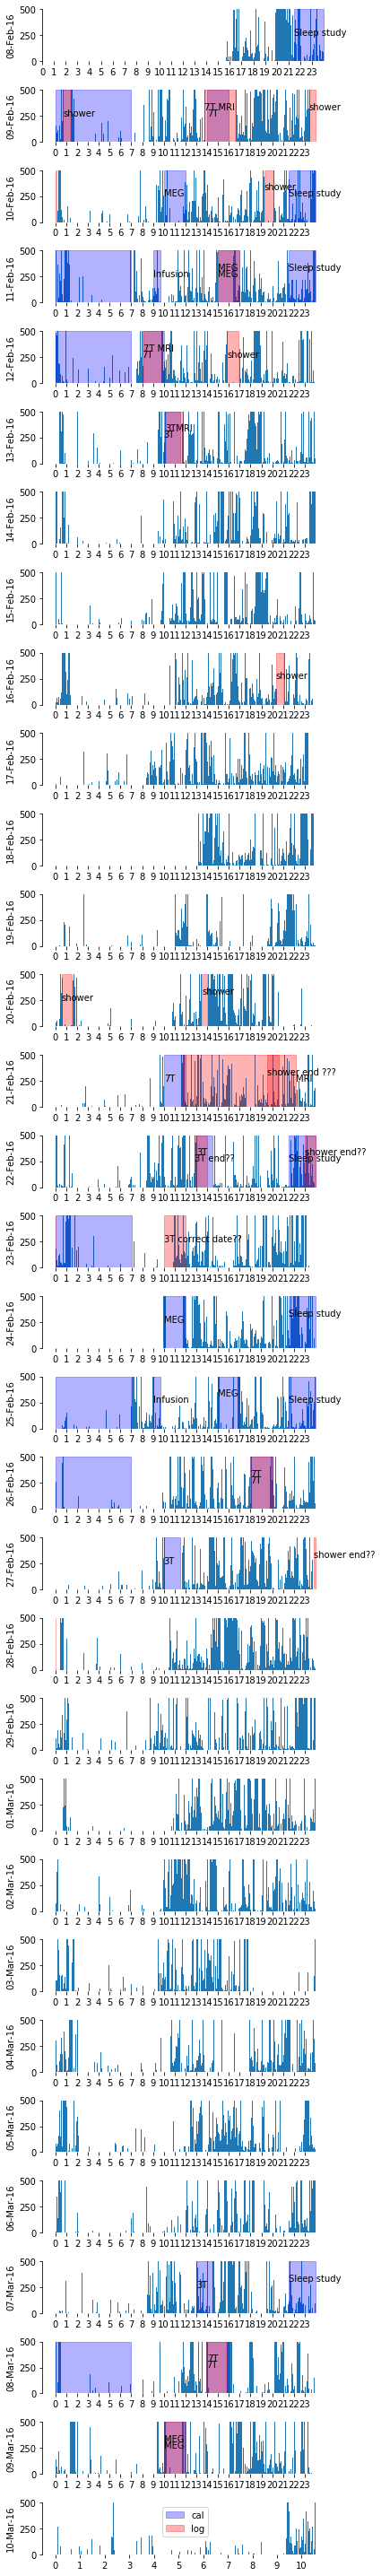

In [185]:
importlib.reload(act)

act.plot_awd(clip_dat,plots,max_act=500,show=False,comments=gc,fn_pref=os.path.join(out_dir,sub_long+'_M+logs'),plot_type='single',debug=True)


32
12-Mar-12
0 479
input 0 [-60, 180, -330]
plot this [-60, 180, -330, 479]
[0 1]
13-Mar-12
480 1919
input 0 [900, -1140, 1260]
plot this [-480, 900, -1140, 1260]
[2]
14-Mar-12
1920 3359
input 0 [-3210]
plot this [-3210, 3359]
[3]
15-Mar-12
3360 4799
input 0 [3780, -3900, 3940, -4380, 4500, -4650]
plot this [-3360, 3780, -3900, 3940, -4380, 4500, -4650, 4799]
[4 5 6]
16-Mar-12
4800 6239
input 0 [5220, -5580, 5700]
plot this [-4800, 5220, -5580, 5700]
[7]
17-Mar-12
6240 7679
input 0 [-7020, 7110]
plot this [-7020, 7110]
[8]
18-Mar-12
7680 9119
input 0 []
[]
19-Mar-12
9120 10559
input 0 []
[]
20-Mar-12
10560 11999
input 0 []
[]
21-Mar-12
12000 13439
input 0 []
[]
22-Mar-12
13440 14879
input 0 []
[]
23-Mar-12
14880 16319
input 0 []
[]
24-Mar-12
16320 17759
input 0 []
[]
25-Mar-12
17760 19199
input 0 []
[]
26-Mar-12
19200 20639
input 0 [-20070, 20160, -20220, 20340, -20490]
plot this [-20070, 20160, -20220, 20340, -20490, 20639]
[ 9 10 11]
27-Mar-12
20640 22079
input 0 [21060, -21360, 2148

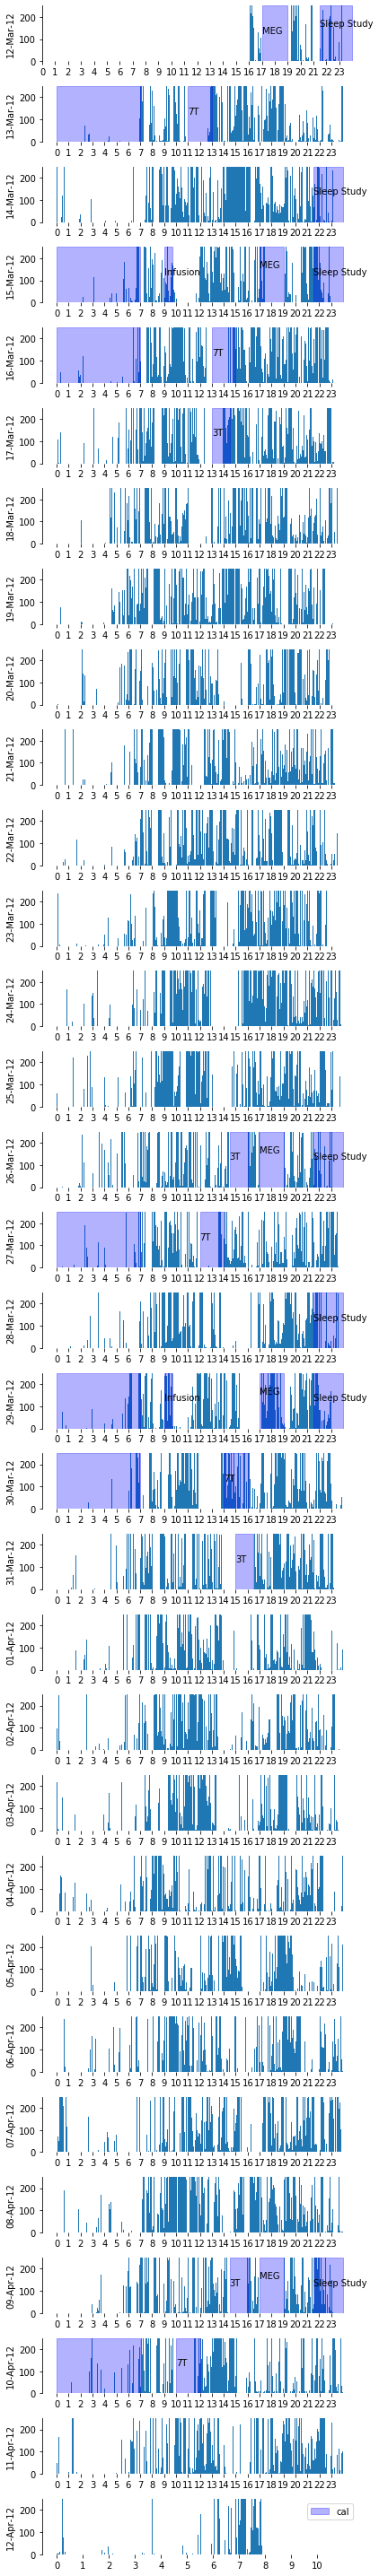

In [31]:
importlib.reload(act)

act.plot_awd(clip_dat,plots,max_act=250,show=False,comments=gc,fn_pref=os.path.join(out_dir,sub_long+'_M+logs_zoom'),plot_type='single',debug=True)
